# Введение в pytorch

**Разработчик: Алексей Озерин**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week02_backpropagation/homework.ipynb)


# Устанавливаем pytorch

## Linux/Mac/Windows


На оффсайте pytorch.org/get-started/ надо выбрать подходящую конфигурацию и установить пакеты pytorch (версия 1.12) и соответствующий torchvision.

На своей машине бывает удобно устанавливать нужные версии python, pytorch и torchvision с помощью [conda](https://docs.conda.io/en/latest/miniconda.html) в [виртуальное окружение](https://docs.python.org/3/tutorial/venv.html) ([документация конды](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) про это)

В Google Colab на осень 2022 уже установлены нужные версии pytorch и torchvision

In [ ]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week02_backpropagation/util.py"
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week02_backpropagation/progress.png"

util.py             100%[===================>]   3.06K  --.-KB/s    in 0s      
progress.png        100%[===================>]  13.76K  --.-KB/s    in 0s      


In [ ]:
import torch
import numpy as np

In [ ]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=0)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[6. 7. 8. 9.]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [ ]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений.

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.int64)
```


Легко конвертировать между собой:

```
torch.from_numpy(npx) -- вернет Tensor
tt.numpy() -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```
torch.tensor([1]).item() -> 1
```


Если что:
- смотрите документацию https://pytorch.org/docs/
- гуглите (Stackoverflow/tutorials)

In [ ]:
x = torch.linspace(0, 2 * np.pi, 16, dtype=torch.float64)

#Mini-task: compute a vector of sin^2(x) + cos^2(x)
out = np.sin(x)**2 + np.cos(x)**2

print(out.numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Automatic gradients

У каждого тензора в Pytorch есть флаг `requires_grad`, который отвечает за автоматическое вычисление градиентов:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grads`


Есть два важных отличия Pytorch от Theano/TF:

1. Функцию ошибки можно изменять динамически, например на каждом минибатче.

2. После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять (или [присваивать им None](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) для экономии памяти).



## Leaf vs Non-leaf Variable:
```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf tensor`.
Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются `leaf tensors` по умолчанию.


Обратите внимание, что вычисление градиентов работает только для тензоров с вещественным типом данных:

In [ ]:
# will not work
x = torch.tensor([1.2, 13.2, 2., 5.], requires_grad=True)


Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()`, `detach` или `torch.inference_mode` (подробнее о различиях между ними [здесь](https://pytorch.org/docs/stable/notes/autograd.html#locally-disabling-gradient-computation)):

In [ ]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(y)
    print(z.requires_grad)

# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


Рассмотрим пример линейной регрессии на датасете Boston

In [ ]:
from torch.autograd import Variable

In [ ]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]


In [ ]:
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

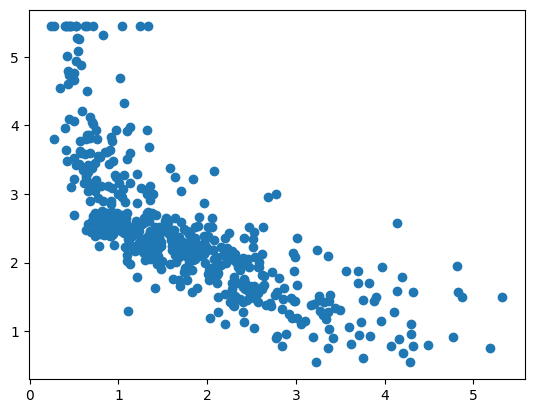

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x, y = data, target

#select one column for simplicity.
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [ ]:
# model tensors
w = Variable(torch.zeros(1), requires_grad=True)
b = Variable(torch.zeros(1), requires_grad=True)

# data tensors
x = Variable(torch.from_numpy(x)).type(torch.FloatTensor)
y = Variable(torch.from_numpy(y)).type(torch.FloatTensor)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

TypeError: ignored

In [ ]:
#try out gradients
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# no gradients for tensors with requires_grad=False
# and non-leaf tensors
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 tensor([-7.2240])
dL/db = 
 tensor([-4.9048])
Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


<ipython-input-43-410d2a980d79>:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print("Non-Leaf loss dL/dpred = \n", y_pred.grad)


## Градиенты промежуточных вершин

В графе, который мы описали `x` и `y_pread` не являются листовыми вершинами. По умолчанию для них не сохраняются градиенты.

Для промежуточных вершин мы можем запросить сохранение градиентов с помощью функции `.retain_grad()`.


In [ ]:
y

tensor([2.6121, 2.3509, 3.7767, 3.6352, 3.9399, 3.1236, 2.4924, 2.9495, 1.7958,
        2.0570, 1.6326, 2.0570, 2.3618, 2.2203, 1.9808, 2.1659, 2.5141, 1.9047,
        2.1985, 1.9808, 1.4802, 2.1332, 1.6543, 1.5781, 1.6979, 1.5128, 1.8067,
        1.6108, 2.0026, 2.2856, 1.3822, 1.5781, 1.4367, 1.4258, 1.4693, 2.0570,
        2.1767, 2.2856, 2.6883, 3.3522, 3.7984, 2.8951, 2.7536, 2.6883, 2.3074,
        2.1006, 2.1767, 1.8067, 1.5673, 2.1114, 2.1441, 2.2312, 2.7209, 2.5468,
        2.0570, 3.8528, 2.6883, 3.4393, 2.5359, 2.1332, 2.0353, 1.7414, 2.4162,
        2.7209, 3.5916, 2.5577, 2.1114, 2.3944, 1.8938, 2.2747, 2.6339, 2.3618,
        2.4815, 2.5468, 2.6230, 2.3291, 2.1767, 2.2638, 2.3074, 2.2094, 3.0474,
        2.6012, 2.6992, 2.4924, 2.6012, 2.8951, 2.4488, 2.4162, 2.5686, 3.1236,
        2.4597, 2.3944, 2.4924, 2.7209, 2.2421, 3.0910, 2.3291, 4.2120, 4.7671,
        3.6134, 2.9930, 2.8842, 2.0244, 2.1006, 2.1876, 2.1223, 2.1223, 2.2203,
        2.1550, 2.1114, 2.3618, 2.4815, 

In [ ]:
y_pred

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
y_pred = w * x + b

# check this:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 tensor([-0.0103, -0.0093, -0.0149, -0.0144, -0.0156, -0.0123, -0.0099, -0.0117,
        -0.0071, -0.0081])


# Линейная регрессия

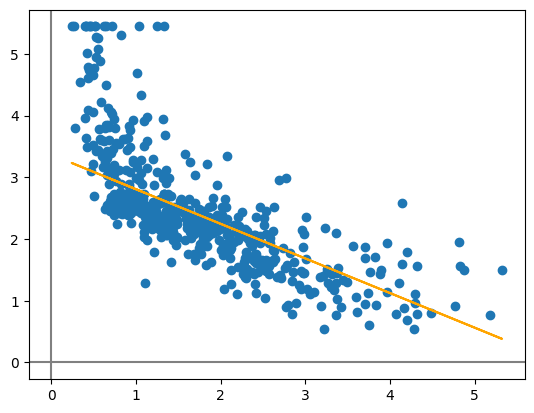

loss =  0.4934180676937103
Done!


In [ ]:
from IPython.display import clear_output

for i in range(100):

    #compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)

    # backprop
    loss.backward()

    # gradient descent step for weights
    # take alpha about 0.1
    w.data -= 0.1*w.grad.data
    b.data -= 0.1*b.grad.data

    #zero gradients
    w.grad.zero_()
    b.grad.zero_()

    #the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(),y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты





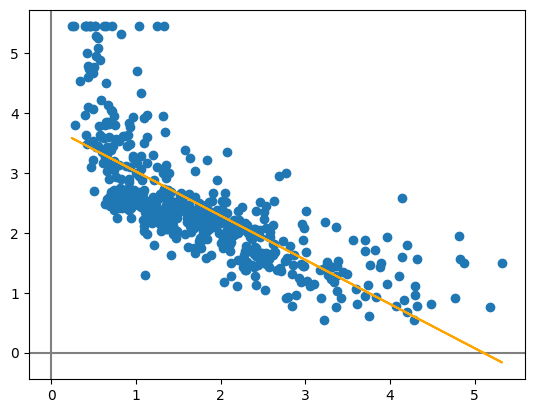

loss =  0.4558538496494293


In [ ]:
# get data
x, y = data, target
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # compute loss
    y_pred = w*x + b
    loss = torch.mean((y - y_pred)**2)

    # backprop and gradient descent
    loss.backward()
    opt.step()
    opt.zero_grad()

    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.2:
            print("Done!")
            break

## Highlevel-API

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. Pytorch предоставляет высокоуровневый API для моделей http://pytorch.org/docs/master/nn.html#torch.nn.Module.


Чтобы воспользоваться моделью необходимо отнаследоваться от torch.nn.Module, определить слои и описать `forward`, `backward` будет вычислен автоматически.


Для демонстрации снова воспользуемся MNIST'ом.

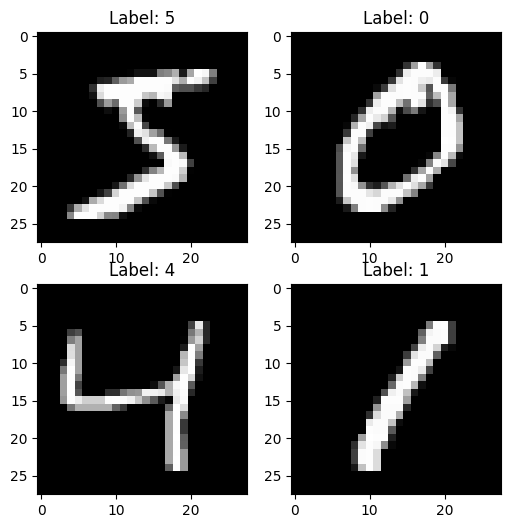

In [ ]:
# MNIST again
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [ ]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # check log_softmax signature
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly

In [ ]:
# model interface:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
# TODO: получите вероятности из output c помощью функций из torch
# hint: см документацию к log_softmax
probs = torch.exp(output)
print('Probs: \n', probs)

# TODO: получите предсказание из output c помощью функций из torch
_, pred = torch.max(probs, dim=1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.3859, -2.1747, -2.3650, -2.1648, -2.3209, -2.3929, -2.3359, -2.2486,
         -2.2947, -2.3749],
        [-2.3737, -2.1751, -2.3671, -2.1490, -2.3495, -2.3680, -2.3612, -2.2472,
         -2.2931, -2.3767],
        [-2.3705, -2.1507, -2.3673, -2.1817, -2.3174, -2.3863, -2.3425, -2.2548,
         -2.2939, -2.3946],
        [-2.3517, -2.1792, -2.3740, -2.1651, -2.3458, -2.3832, -2.3219, -2.2535,
         -2.2939, -2.3882],
        [-2.3813, -2.1745, -2.3616, -2.1589, -2.3310, -2.3970, -2.3272, -2.2441,
         -2.3027, -2.3815],
        [-2.3793, -2.1519, -2.3657, -2.1633, -2.3237, -2.3784, -2.3451, -2.2649,
         -2.3037, -2.3847],
        [-2.3836, -2.1950, -2.3534, -2.1513, -2.3454, -2.3690, -2.3473, -2.2467,
         -2.2853, -2.3800],
        [-2.3973, -2.1709, -2.3499, -2.1602, -2.3198, -2.3732, -2.3416, -2.2642,
         -2.3111, -2.3692],
        [-2.3722, -2.1865, -2.3531, -2.1682, -2.3437, -2.3882, -2.3394, -2.2462,
         -2.2868, -2.3708],
  

Тренировка сети

Для тренировки сети нам требуется
- итератор по данным
- функция тренировки (прогон по данным, вычисление и применение градиентов)
- функция валидации (прогон по тестовым данным, вычисление метрик)

In [ ]:
from IPython.display import clear_output
from tqdm.auto import tqdm

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [92]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


# TODO: написать функцию для валидации по X_val, y_val
# hint: optimizer не нужен
def test(model):
    loss_log = []
    model.eval()

    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=batchsize, shuffle=True):
      data = torch.from_numpy(x_batch.astype(np.float32))
      target = torch.from_numpy(y_batch.astype(np.int64))

      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()

      loss = loss.item()
      loss_log.append(loss)

    return loss_log

Для отслеживания процедуры тренировки построить график вида
![img](./progress.png)

In [93]:
EPOCH_STEPS = 1600

In [142]:
def plot_history(train_history, val_history, epoch, title='loss'):
    plt.figure()
    plt.plot(train_history)
    plt.plot(epoch * EPOCH_STEPS, val_history)
    plt.xlabel('Train steps')
    plt.title("Loss at %i epoch"%(epoch+1)[-1])
    plt.show()

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

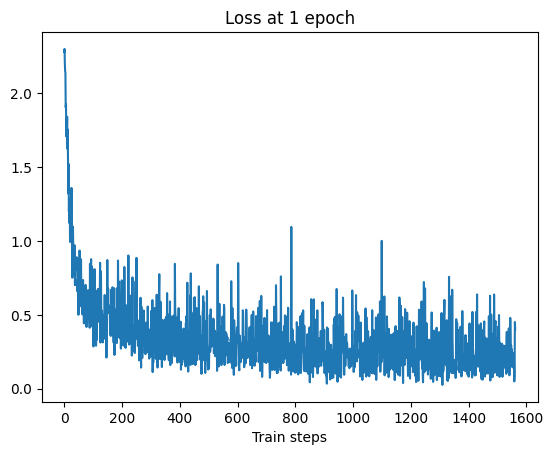

In [95]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32
EPOCH_NUMS = 1
epoch_range = np.arange(0,EPOCH_NUMS)

for epoch in epoch_range:
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)

    val_loss = np.mean(test(model))
    val_log.append(val_loss)

plot_history(train_log, val_log, epoch_range)

    # TODO: график train_loss vs train_steps с точками val_loss vs trained_steps

    # use your plot_history()

    # hint: train_log and val_log may contain data with different shapes

## Метрики

Logloss -- величина, которую трудно интерпретировать.
Для отслеживания тренировки и сравнения моделей удобнее наблюдать за интерпретируемыми метриками, например точностью (accuracy)

Модифицируйте код train/test функций так, чтобы помимо ошибки подсчитывалась точность за батч:

In [109]:
torch.max(torch.Tensor([1,2,3,4])).numpy()

array(4., dtype=float32)

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

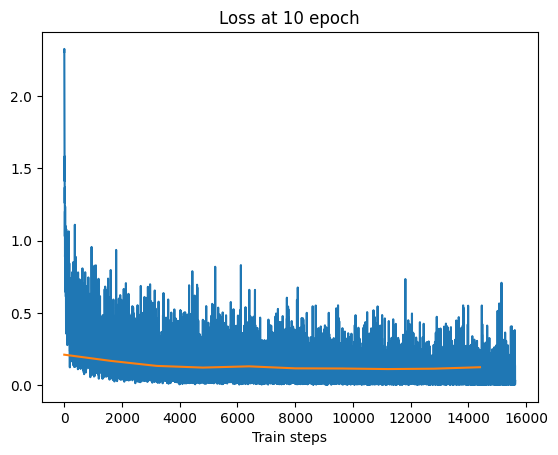

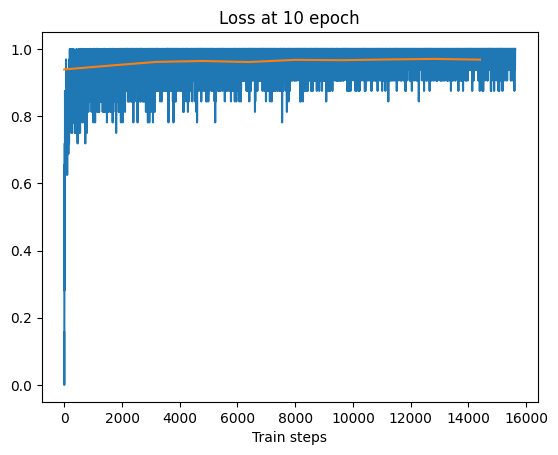

In [152]:
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []

    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = Variable(torch.from_numpy(x_batch.astype(np.float32)))
        target = Variable(torch.from_numpy(y_batch.astype(np.int64)))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #добавляем вычисление accuracy
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()

        loss = loss.detach().numpy()
        loss_log.append(loss)

    return loss_log, acc_log


# TODO: добавьте подсчет точности:
def test(model):
    loss_log, acc_log = [], []
    model.eval()

    tt = Variable(torch.from_numpy(X_val.astype(np.float32)))
    target = Variable(torch.from_numpy(y_val.astype(np.int64)))
    output = model.forward(tt)

    probs = torch.exp(output)
    _ , pred = torch.max(probs, dim=1)

    loss = F.nll_loss(output, target)
    loss_log.append(loss.data)

    #добавляем вычисление accuracy
    pred = torch.max(output, 1)[1].data.numpy()
    acc = np.mean(pred == y_val)
    acc_log.append(acc)

    return loss_log, acc_log



train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32
EPOCH_NUMS = 10

range_e = np.arange(0,EPOCH_NUMS)
for epoch in range_e:
    # train
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)

    # test
    val_loss, val_acc = test(model)
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)


    # store metrics
    val_log.append(val_loss)
    val_acc_log.append(val_acc)

# plot all metrics (loss and acc for train/val)
plot_history(train_log, val_log, range_e) #сразу построим до конца на одном графике
plot_history(train_acc_log, val_acc_log, range_e)

## Fine Tuning
Для многих прикладных задач не существует больших датасетов с хорошей разметкой.
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Finetuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети -- это набор сверток и пулингов (convolutions and poolings)
- голову -- это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является переучивание головы сети.


Нам потребуется [предобученная модель](http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) и датасет для нашей задачи.

Предлагется воспользоваться моделью для ImageNet и датасетом  https://download.pytorch.org/tutorial/hymenoptera_data.zip


В датасете содержатся картинки двух классов (`ants` и `bees`) разных размеров.

In [153]:
# На Windows придется скачать архив по ссылке (~45Mb) и распаковать самостоятельно
!wget --quiet --show-progress "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip -q ./hymenoptera_data.zip

hymenoptera_data.zi 100%[===================>]  45.10M   192MB/s    in 0.2s    


Загрузчик данных -- одна из важных компонент для эффективного обучения нейронных сетей:
асинхронная загрузка и быстрая предобработка важны для полного использования GPU. В pytorch для этого есть https://pytorch.org/docs/stable/data.html

Пример использования:

In [154]:
%matplotlib inline

import time
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


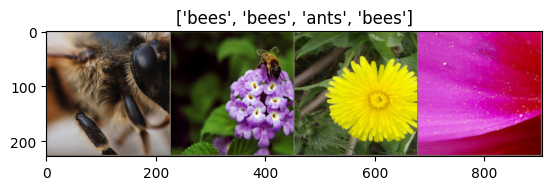

In [155]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [156]:
# обратите внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [157]:
# torchvision содержит ряд моделей с претрейненными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [169]:
model_ft = models.resnet18(pretrained=True)

model_ft.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [170]:
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()

# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])

# TODO: подмените в модели последний слой, чтобы она работала для двух классов

model = model_ft.fc.out_features = 2

# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?
# например, выключить обучение всех параметров можно при помощи этого кода:
# for params in model_ft.parameters():
#     params.requires_grad = False

for params in model_ft.parameters():
    params.requires_grad = False

params_to_train = model_ft.parameters()

for params in model_ft.fc.parameters():
    params.requires_grad = True

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [171]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# если всё сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.war

train Loss: 0.4194 Acc: 0.5984
val Loss: 0.1011 Acc: 0.8758
Elapsed 0m 29s

Epoch 1/24
----------
train Loss: 0.1126 Acc: 0.7705
val Loss: 0.1107 Acc: 0.8562
Elapsed 1m 0s

Epoch 2/24
----------
train Loss: 0.1185 Acc: 0.8156
val Loss: 0.0660 Acc: 0.9150
Elapsed 1m 26s

Epoch 3/24
----------
train Loss: 0.1095 Acc: 0.8279
val Loss: 0.0737 Acc: 0.9085
Elapsed 1m 51s

Epoch 4/24
----------
train Loss: 0.1178 Acc: 0.7951
val Loss: 0.0907 Acc: 0.8627
Elapsed 2m 17s

Epoch 5/24
----------
train Loss: 0.1121 Acc: 0.7992
val Loss: 0.0528 Acc: 0.9412
Elapsed 2m 43s

Epoch 6/24
----------
train Loss: 0.0933 Acc: 0.8361
val Loss: 0.0490 Acc: 0.9346
Elapsed 3m 9s

Epoch 7/24
----------
train Loss: 0.0722 Acc: 0.8852
val Loss: 0.0589 Acc: 0.9281
Elapsed 3m 35s

Epoch 8/24
----------
train Loss: 0.0874 Acc: 0.8402
val Loss: 0.0530 Acc: 0.9412
Elapsed 4m 0s

Epoch 9/24
----------
train Loss: 0.1058 Acc: 0.8361
val Loss: 0.0587 Acc: 0.9412
Elapsed 4m 26s

Epoch 10/24
----------
train Loss: 0.0771 Acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


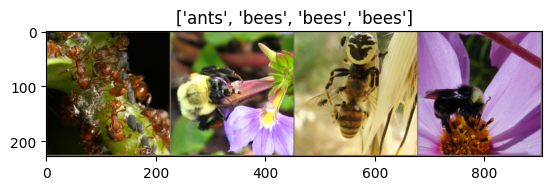

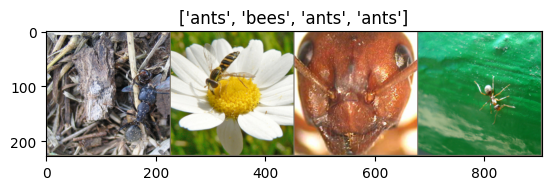

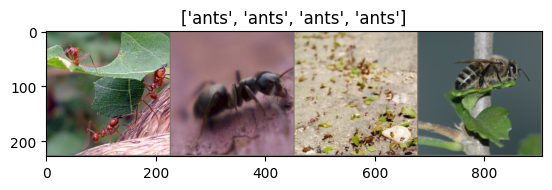

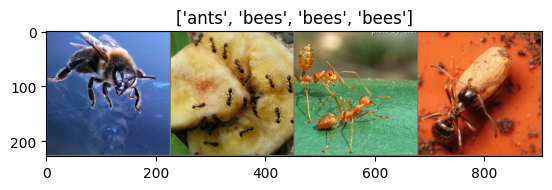

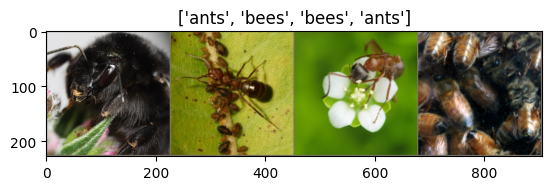

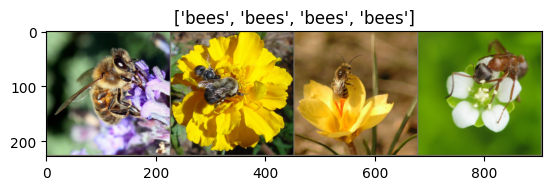

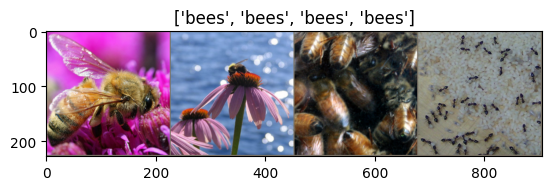

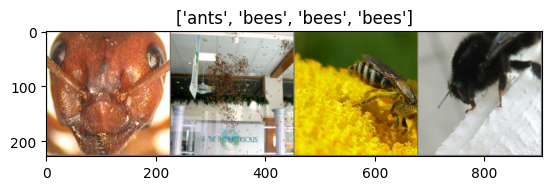

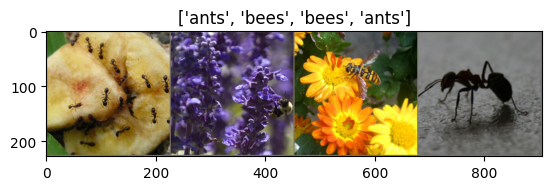

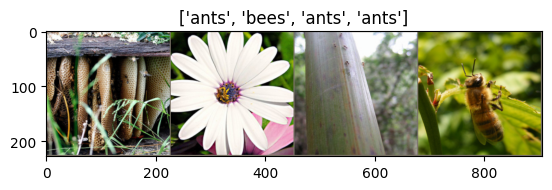

In [173]:
# TODO: напишите функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразите картинки и предсказания

def visualize(model, num_images=10):
    for i in range(num_images):
      inputs, classes = next(iter(dataloaders['val']))
      out = torchvision.utils.make_grid(inputs)

      pred = torch.max(model(Variable(inputs)), dim=1)[1]

      imshow(out, title=[class_names[pred.data[x]] for x in pred.data])

visualize(model_ft)